# One-hot HMM-GLM on A Synthetic Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from hmmglm.deprecated import model, nonlinearities, utils, distributions

## HMM-GLMs
* Spike train data: $\boldsymbol X\in\mathbb N^{T\times N}$, $N$ neurons, $T$ time bins.
* Assume there are exist $S$ states underlying the functional connectivities of neural ativity.
* For each time $t$, we introduce a discrete latent variable $z_t\in\{1,\dots,S\}$, whose transition probability is $p(z_{t+1}|z_t) = \pi_{z_t,z_{t+1}}$.

Given a latent state $z_t$, the weight matrix at time $t$ is selected as $\boldsymbol W_{z_t}\in\mathbb R^{n\times n}$ from $\{\boldsymbol W_s\}_{s=1}^S$. Then the emission model is $p(x_{t,n}|z_t,\boldsymbol x_1,\dots,\boldsymbol x_{t-1}) = \operatorname{Poisson}(f_{t,n})$:

$$ f_{t,n} = \sigma\left(b_n + \sum_{n'=1}^N w_{z_t,n\gets n'}\cdot \left(\sum_{k=1}^K x_{t-k,n'}\phi_k\right)\right) $$

* $\sigma: \mathbb R\to \mathbb R_+$ is a nonlinear activation function.
* $b_n$ is the background intensity of the $n$-th neuron.
* $w_{s,n\gets n'}$ is the weight from neuron $n'$ to neuron $n$ in state $s$.
* $\boldsymbol \phi\in\mathbb R_+^K$ is the basis function summarizing history spikes from $t-K$ to $t-1$.

## 1 Data generation

In [72]:
n_states, n_neurons = 5, 20

decay = 1
window_size = 5
basis = utils.exp_basis(decay=1, window_size=window_size, time_span=window_size)
print(f'basis: {basis}')

sparsity, p_exc = 1/5, 1/2

n_samples = 50
n_samples_train = 30
n_time_bins = 2000

basis: tensor([0.6364, 0.2341, 0.0861, 0.0317, 0.0117])


In [76]:
trial = 0
torch.manual_seed(trial)

dirichlet_distribution = Dirichlet(torch.tensor([sparsity * (1-p_exc), (1-sparsity), sparsity * p_exc]) * 2)
distribution = distributions.Poisson()

gen_model = model.OnehotHMMGLM(n_states, n_neurons, basis=basis, distribution=distribution, activation=nonlinearities.Sigmoid())
gen_model._adjacency_prior.data = torch.log(dirichlet_distribution.sample(sample_shape=(n_neurons, n_neurons)))
gen_model._strength.data = torch.log(3 * torch.rand((n_states, n_neurons, n_neurons)))
gen_model.sample_adjacency()
gen_model._bias.data = 0.1 * (torch.rand((n_neurons)) - 0.5)

# simulate data
gen_model.set_adjacency_type('hard')
spikes_list, convolved_spikes_list, firing_rates_list, states_list = gen_model.sample(n_time_bins, n_samples)

Text(0.02, 0.5, 'neuron')

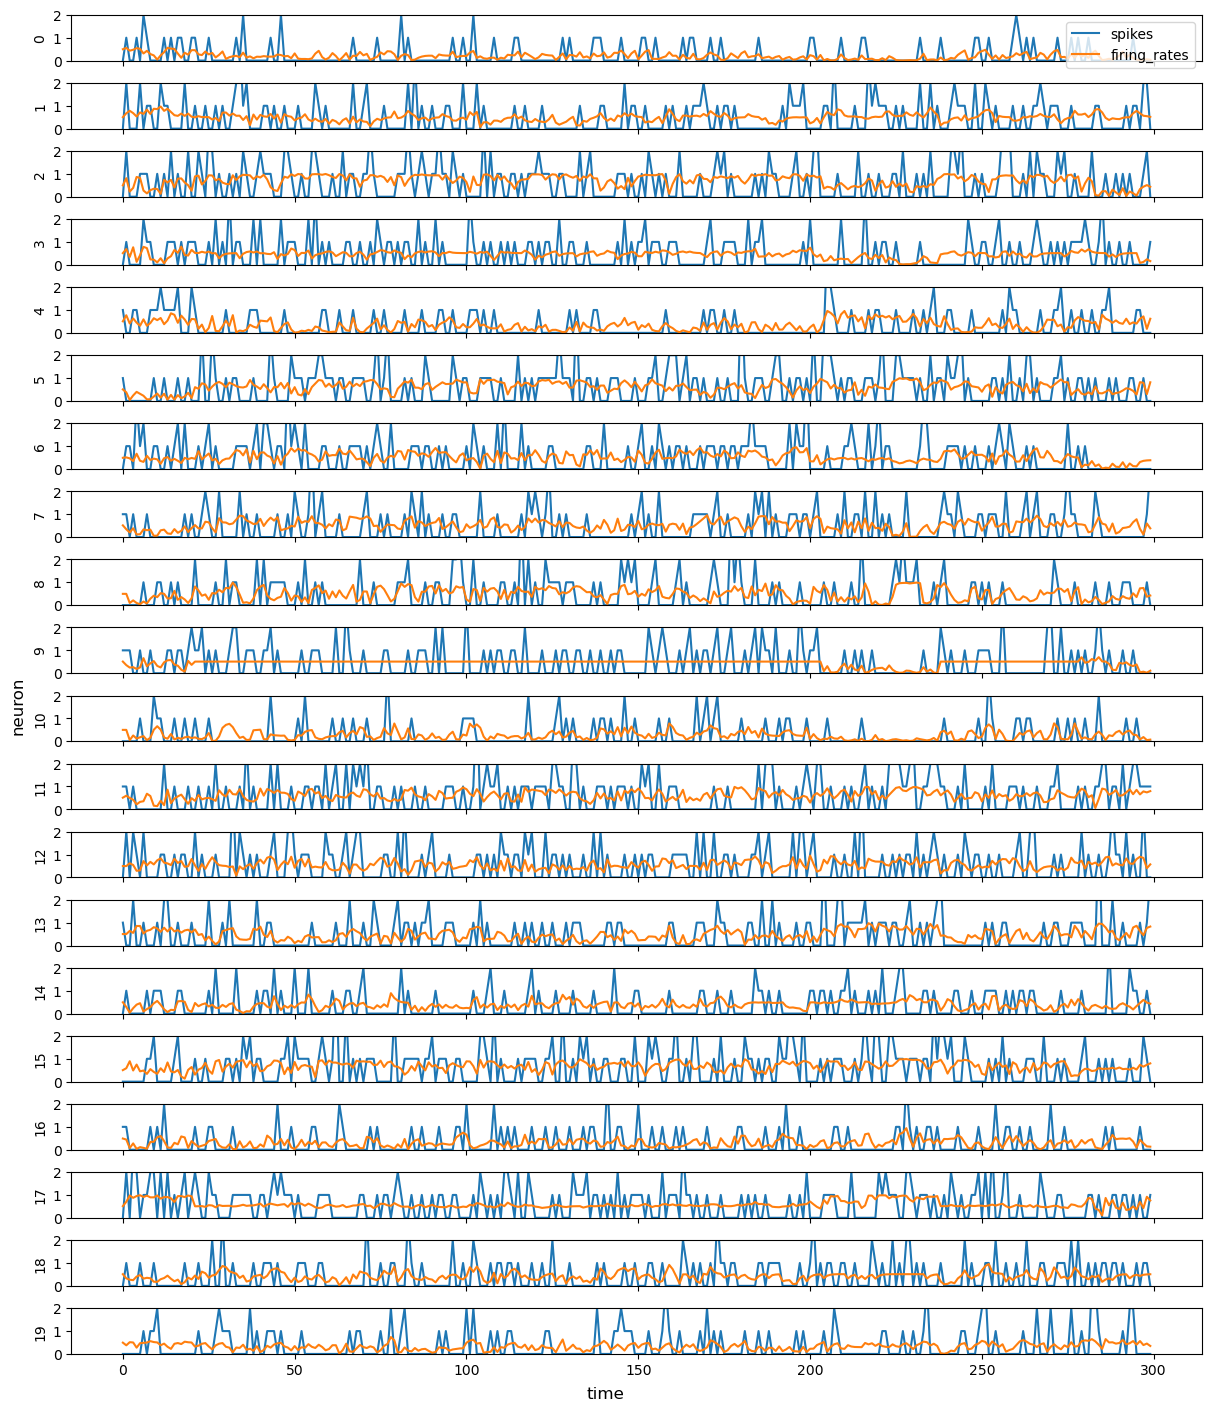

In [87]:
# Visualize one spike train

fig, axs = plt.subplots(n_neurons, 1, figsize=(12, 14), layout='constrained', sharex=True)
sample = 0
for neuron in range(n_neurons):
    ax = axs[neuron]
    ax.plot(spikes_list[sample, :300, neuron], label='spikes')
    ax.plot(firing_rates_list[sample, :300, neuron], label='firing_rates')
    ax.set(ylabel=f'{neuron}', yticks=[0, 1, 2], ylim=(0, 2))
axs[0].legend(loc='upper right')
fig.supxlabel('time')
fig.supylabel('neuron')

## 2 Train different models

In [161]:
model_dict = dict()
model_list = ['HMM-GLM', 'Gaussian HMM-GLM', 'One-hot HMM-GLM']
abbr_list = ['HG', 'GHG', 'OHG']

### 2.1 Naive HMM-GLM

In [168]:
def train_hmmglm(
        inf_model: model.HMMGLM,
        optimizer: torch.optim.Optimizer,
        spikes_list: torch.FloatTensor,
        convolved_spikes_list: torch.FloatTensor,
        n_epochs: int = 100,
        print_freq: int = 1,
        n_sub_epochs: int = 100
) -> torch.FloatTensor:
    
    n_samples, n_time_bins, n_neurons = spikes_list.shape

    epoch_loss_list = torch.zeros(n_epochs)
    print('epoch', 'loss')

    for epoch in range(n_epochs):
        for sample in range(n_samples):
            spikes = spikes_list[sample]
            convolved_spikes = convolved_spikes_list[sample]

            gamma, xi = inf_model.forward_backward(spikes, convolved_spikes)
            for sub_epoch in range(n_sub_epochs):
                loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            epoch_loss_list[epoch] += loss.item()
        if epoch % print_freq == 0:
            print(epoch, epoch_loss_list[epoch].item(), flush=True)
    
    return epoch_loss_list

In [169]:
inf_model = model.NaiveHMMGLM(n_states, n_neurons, basis, distributions.Poisson(), nonlinearities.Sigmoid())
inf_model._bias.data = spikes_list[:n_samples_train].mean(dim=(0, 1))
optimizer = torch.optim.Adam(inf_model.parameters(), lr=0.01)

n_epochs = 10
print_freq = 1
n_sub_epochs = 50

# n_epochs = 100
# print_freq = 10
# n_sub_epochs = 5

torch.manual_seed(0)
epoch_loss_list = train_hmmglm(inf_model, optimizer, spikes_list[:n_samples_train], convolved_spikes_list[:n_samples_train], n_epochs, print_freq, n_sub_epochs)

# permute states according to the first sample sequence
with torch.no_grad():
#     true_to_learned = utils.match_weights(gen_model.weight, inf_model.weight)
    gamma = inf_model.forward_backward(spikes_list[0], convolved_spikes_list[0])[0]
    true_to_learned = utils.match_states(F.one_hot(states_list[0], n_states), gamma)
    inf_model.permute_states(true_to_learned)

model_dict['HMM-GLM'] = inf_model

epoch loss
0 1009413.5625
1 1000569.25
2 1000320.625
3 1000183.25
4 1000020.8125
5 999764.0
6 999622.875
7 999142.75
8 998610.9375
9 997776.125


### 2.2 Gaussian HMM-GLM

In [96]:
def train_gaussian_hmmglm(
        inf_model: model.HMMGLM,
        optimizer: torch.optim.Optimizer,
        spikes_list: torch.FloatTensor,
        convolved_spikes_list: torch.FloatTensor,
        n_epochs: int = 100,
        print_freq: int = 1,
        n_sub_epochs: int = 100
) -> torch.FloatTensor:
    
    n_samples, n_time_bins, n_neurons = spikes_list.shape

    epoch_loss_list = torch.zeros(n_epochs)
    print('epoch', 'loss')

    for epoch in range(n_epochs):
        for sample in range(n_samples):
            spikes = spikes_list[sample]
            convolved_spikes = convolved_spikes_list[sample]

            gamma, xi = inf_model.forward_backward(spikes, convolved_spikes)
            for sub_epoch in range(n_sub_epochs):
                inf_model.update_weight_prior_mean()
                loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi) - inf_model.weight_prior_log_likelihood()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            epoch_loss_list[epoch] += loss.item()
        if epoch % print_freq == 0:
            print(epoch, epoch_loss_list[epoch].item(), flush=True)
    
    return epoch_loss_list

In [170]:
inf_model = model.GaussianHMMGLM(n_states, n_neurons, basis, distributions.Poisson(), nonlinearities.Sigmoid())
inf_model._bias.data = spikes_list[:n_samples_train].mean(dim=(0, 1))
optimizer = torch.optim.Adam(inf_model.parameters(), lr=0.01)

n_epochs = 10
print_freq = 1
n_sub_epochs = 50

# n_epochs = 100
# print_freq = 10
# n_sub_epochs = 5

torch.manual_seed(0)
epoch_loss_list = train_gaussian_hmmglm(inf_model, optimizer, spikes_list[:n_samples_train], convolved_spikes_list[:n_samples_train], n_epochs, print_freq, n_sub_epochs)

# permute states according to the first sample sequence
with torch.no_grad():
#     true_to_learned = utils.match_weights(gen_model.weight, inf_model.weight)
    gamma = inf_model.forward_backward(spikes_list[0], convolved_spikes_list[0])[0]
    true_to_learned = utils.match_states(F.one_hot(states_list[0], n_states), gamma)
    inf_model.permute_states(true_to_learned)

model_dict['Gaussian HMM-GLM'] = inf_model

epoch loss
0 1003572.375
1 990704.625
2 990691.375
3 990687.3125
4 990685.625
5 990685.8125
6 990685.0
7 990685.5
8 990685.5
9 990684.9375


### 2.3 One-hot HMM-GLM

In [98]:
def train_onehot_hmmglm(
        inf_model: model.HMMGLM,
        optimizer: torch.optim.Optimizer,
        spikes_list: torch.FloatTensor,
        convolved_spikes_list: torch.FloatTensor,
        n_epochs: int = 100,
        print_freq: int = 1,
        n_sub_epochs: int = 100
) -> torch.FloatTensor:
    
    n_samples, n_time_bins, n_neurons = spikes_list.shape

    epoch_loss_list = torch.zeros(n_epochs)
    print('epoch', 'loss')

    for epoch in range(n_epochs):
        for sample in range(n_samples):
            spikes = spikes_list[sample]
            convolved_spikes = convolved_spikes_list[sample]

            gamma, xi = inf_model.forward_backward(spikes, convolved_spikes)
            inf_model.set_adjacency_type('gumbel_softmax')
            for sub_epoch in range(n_sub_epochs):
                loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi) - inf_model.adjacency_prior_log_likelihood()
                # loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi) - inf_model.adjacency_prior_log_likelihood() + inf_model.sampled_adjacency_entropy()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                inf_model.correct_extreme_onehot()
            inf_model.set_adjacency_type('softmax')
            epoch_loss_list[epoch] += loss.item()
        if epoch % print_freq == 0:
            print(epoch, epoch_loss_list[epoch].item(), flush=True)
    
    return epoch_loss_list

In [171]:
inf_model = model.OnehotHMMGLM(n_states, n_neurons, basis, distributions.Poisson(), nonlinearities.Sigmoid(), nonlinearities.Softplus())
inf_model._bias.data = spikes_list[:n_samples_train].mean(dim=(0, 1))
optimizer = torch.optim.Adam(inf_model.parameters(), lr=0.01)

n_epochs = 10
print_freq = 1
n_sub_epochs = 50

# n_epochs = 100
# print_freq = 10
# n_sub_epochs = 5

torch.manual_seed(0)
epoch_loss_list = train_onehot_hmmglm(inf_model, optimizer, spikes_list[:n_samples_train], convolved_spikes_list[:n_samples_train], n_epochs, print_freq, n_sub_epochs)

# permute states according to the first sample sequence
with torch.no_grad():
#     true_to_learned = utils.match_weights(gen_model.weight, inf_model.weight)
    gamma = inf_model.forward_backward(spikes_list[0], convolved_spikes_list[0])[0]
    true_to_learned = utils.match_states(F.one_hot(states_list[0], n_states), gamma)
    inf_model.permute_states(true_to_learned)

inf_model.set_adjacency_type('hard')
model_dict['One-hot HMM-GLM'] = inf_model

epoch loss
0 650083.75
1 -284120.3125
2 -328342.53125
3 -341769.4375
4 -347587.6875
5 -350512.5625
6 -351262.75
7 -351567.0
8 -351720.78125
9 -351760.875


## 3 Visualization

### 3.1 Weight matrices in different states

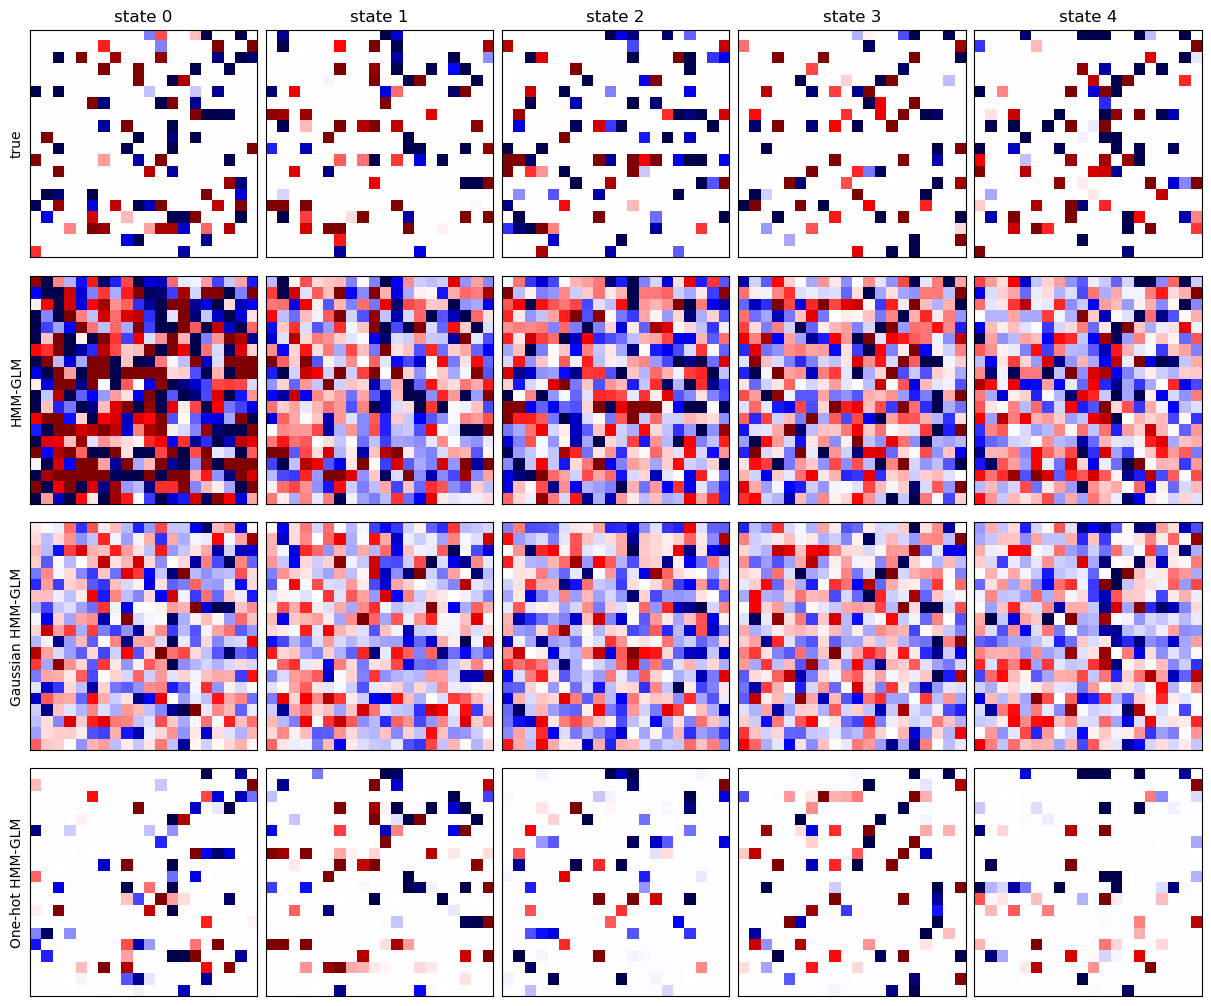

In [172]:
fig, axs = plt.subplots(4, n_states, figsize=(12, 10), layout='constrained')

with torch.no_grad():
    for state in range(n_states):
        utils.visualize_matrix(gen_model.weight[state], axs[0, state], v=1)
        axs[0, state].set_title(f'state {state}')
    axs[0, 0].set(ylabel='true')

    for model_idx in range(len(model_list)):
        model_name = model_list[model_idx]
        for state in range(n_states):
            utils.visualize_matrix(model_dict[model_name].weight[state], axs[model_idx+1, state], v=1)

        axs[model_idx+1, 0].set(ylabel=model_name)

### 3.2 Inferred state sequence

In [173]:
def visualize_states(states: torch.LongTensor, ax):
    ax.matshow(states[None, :], vmin=0, vmax=9, cmap='tab10', aspect='auto')
#     ax.set(xticks=[0, 500, 1000, 1500, 2000], xlabel='time', yticks=[])
#     ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

Text(0.5, 0.01, 'time')

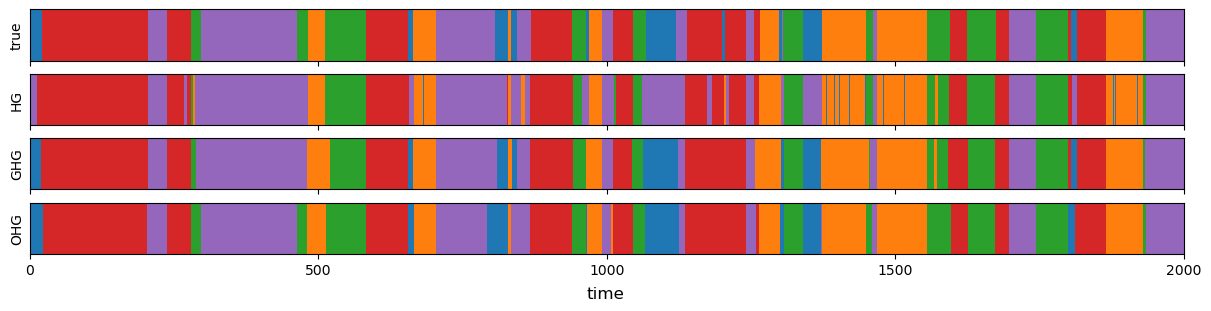

In [174]:
sample = 0

fig, axs = plt.subplots(4, 1, figsize=(12, 3), layout='constrained', sharex=True)
visualize_states(states_list[sample], axs[0])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=False, left=False, labelleft=False)
axs[0].set(ylabel='true')

for model_idx in range(len(model_list)):
    model_name = model_list[model_idx]
    ax = axs[model_idx+1]
    states_inferred = model_dict[model_name].forward_backward(spikes_list[sample], convolved_spikes_list[sample])[0].argmax(dim=-1)
    visualize_states(states_inferred, ax)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=False, left=False, labelleft=False)
    ax.set(ylabel=f'{abbr_list[model_idx]}')
ax.tick_params(labelbottom=True)
ax.set(xticks=[0, 500, 1000, 1500, 2000])
fig.supxlabel('time')